# Segmentación Watershed<a class="tocSkip">
## TRATAMIENTO DE SEÑALES <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Teoría
Cualquier imagen en escala de grises se puede ver como una superficie topográfica donde una intensidad alta indica picos y colinas, mientras que intensidades bajas indican valles. En este algoritmo se empieza por llenar cada valle aislado (mínimos locales) con agua de diferentes colores (etiquetas). A medida que el agua sube, dependiendo de los picos (pendientes) cercanos, el agua de diferentes valles, obviamente con diferentes colores, comenzará a fusionarse. Para evitar esto, se construyen barreras en los lugares donde se une el agua. Luego, se continúa el trabajo de rellenar con agua y construir barreras hasta que todos los picos estén bajo el agua. Así, las barreras creadas en este proceso, no son más que la segmentación de la imagen. Esta es la “filosofía” detrás del algoritmo Watershed.

Sin emabrgo, este enfoque da un resultado sobresegmentado debido al ruido o a cualquier otra irregularidad en la imagen. Así que OpenCV implementó un algoritmo de cuenca hidrográfica basado en marcadores en el que se especifican cuáles son todos los puntos del valle que se fusionarán y cuáles no. Es una segmentación de imagen interactiva. Lo que hacemos es dar diferentes etiquetas a nuestro objeto. De este modo, tendremos que etiquetar la región que estamos seguros de que es el primer plano o el objeto en sí con un color (o intensidad), y debemos etiquetar la región de la que estamos seguros que es el fondo y no el objeto, con otro color. Finalmente la región de la que no estamos seguros de nada la debemos etiquetar con 0. Ese es nuestro marcador. Sólo después de este etiquetado aplicamos el algoritmo Watershed. Entonces nuestro marcador se actualizará con las etiquetas que dimos, y los límites de los objetos tendrán un valor de -1.

A continuación, veremos un ejemplo sobre cómo usar la Transformación de distancia junto con el Watershed para segmentar objetos que se tocan mutuamente.

In [1]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


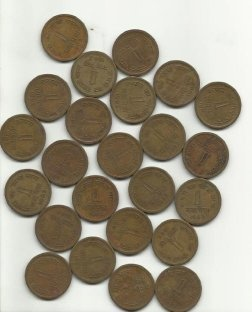

In [2]:
# Plot the image 
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    #Image loading 
img = cv2.imread("coins.jpg")

#image grayscale conversion 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Show image 
imshow(img)


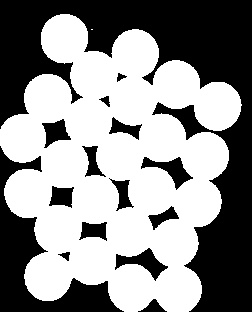

In [3]:
#Threshold Processing 
ret, bin_img = cv2.threshold(gray,
                             0, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)


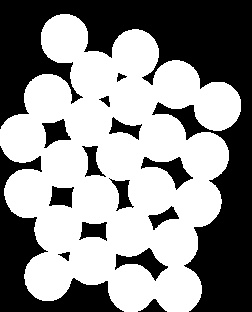

In [4]:
# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
imshow(bin_img) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


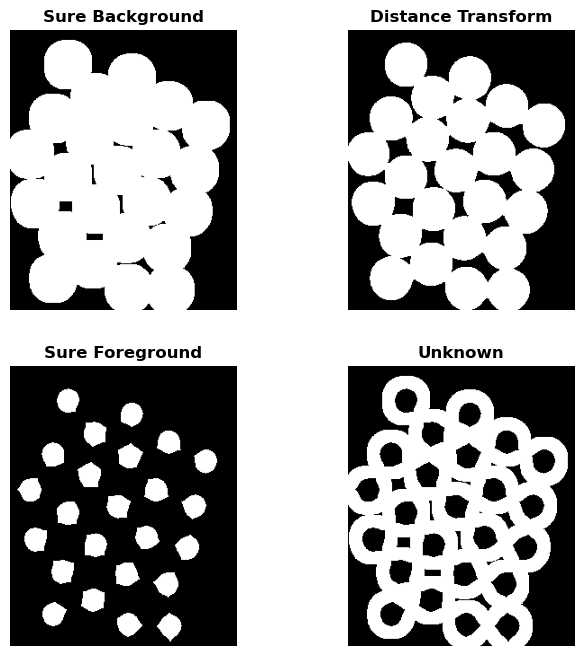

In [5]:
# Create subplots with 1 row and 2 columns 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area 
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform 
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area 
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area 
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


¿Recuerdas que dijimos que para evitar la sobresegmentación típica de watershed, tenemos que pasarle unos marcadores a partir de los cuáles empezar a inundar? Bueno, en nuestro caso, los marcadores serán el producto de hallar las componentes conectadas de la foto:

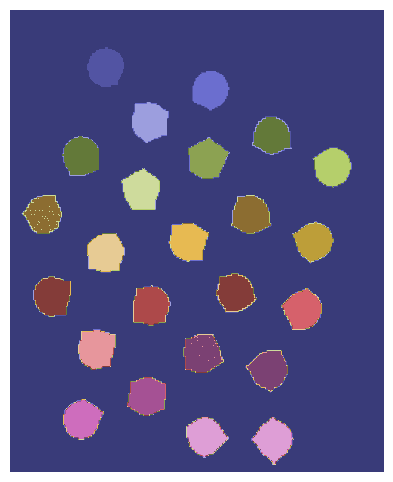

In [6]:
# Marker labelling 
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Para que watershed no considere el fondo como una región desconocida, tenemos que etiquetarla con un valor distinto a 0, por lo que sumamos uno a los markers:
markers += 1
# Ahora sí, usamos el cero para denotar las regiones verdaderamente desconocidas. 
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


Aplicamos watershed sobre la imagen original, con base a los marcadores hallados previamente:

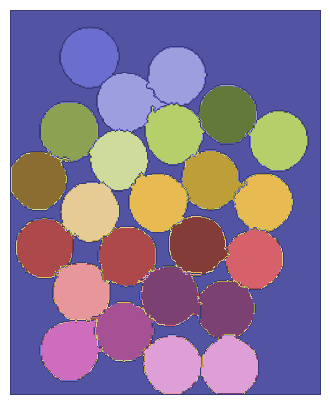

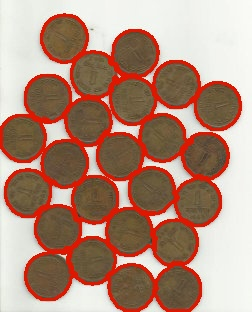

In [7]:
# watershed Algorithm 
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

    # Create a binary image in which only the area of the label is in the foreground 
    #and the rest of the image is in the background 
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Perform contour extraction on the created binary image 
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])

# Draw the outline 
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).